# Plant Seedling Classification

* Problem statement: Create a classifier capable of determining a plant's species from a photo
* Dataset to be used: https://www.kaggle.com/c/plant-seedlings-classification/data
* Training_Info files can be downloaded from this link: [Download Link](https://icedrive.net/0/3dVDk6jgkH)

In [1]:
### Use this for Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import required libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import math
import datetime, os
import shutil
import pprint
import timeit
import pytz
import pickle
from tqdm import tqdm
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import models
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import InverseTimeDecay 

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from xgboost import XGBClassifier
from joblib import dump, load

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext tensorboard

# Kill previous instance of Tensorboard if it exists
shutil.rmtree("C:/Users/Suresh Venkatesan/AppData/Local/Temp/.tensorboard-info",\
              ignore_errors = True)

# Directory paths

In [3]:
### Use this for Google Colab

# # Define base path for TensorBoard Logs directory
tb_logs_base_dir = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Plant_Seedling_Classification/TB_Logs/"
os.makedirs(tb_logs_base_dir, exist_ok = True) # Don't raise any exception if directory exists

# Define base path for storing all outputs related to model / training
out_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Plant_Seedling_Classification/Training_Info/"

# Define base path of dataset
dataset_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Datasets/Image_Datasets/Plant_Seedling_Classification/"

# Import Dataset

## Create images directory in local colab session

In [5]:
### Use this for Google Colab

start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
print("Started local dataset creation at %s" %(start_time.strftime("%H:%M:%S")), end = '; ')

# Copy zip file from zip_file_path
zip_file_path = os.path.join(dataset_path, "Plant_Seedling_Classification.zip")
!cp "{zip_file_path}" .

# Unzip images.zip file
!unzip -q Plant_Seedling_Classification.zip

# Delete zip file
!rm Plant_Seedling_Classification.zip

# Re-point dataset path
dataset_path = "/content/Plant_Seedling_Classification/"

end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
elap_time = ((end_time - start_time).total_seconds())/60
print("Completed at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time)) 


Started local dataset creation at 19:12:58; Completed at 19:14:50. Elapsed time = 1.86 minutes.


## Define required paths

In [6]:
# Define paths for input images
train_set_path = os.path.join(dataset_path, 'train/')
test_set_path = os.path.join(dataset_path, 'test/')

## Preliminary analysis of dataset

The section below is used to parse through the entire dataset directory and collect information about all the images including:
  * Seedling Class
  * File name of image
  * Image, height, width, area and aspect ratio

This information was collected together in a dataframe and written to an xls file. This was done once at the beginning and the xls file was created. Since the xls file has already been created, this section is commented out. The dataframe will be re-loaded back from the xls in subsequent sections.

### Create dataframe

In [7]:
### This section is commented out

# # Create empty dataframe with the right columns
# cols = ['Seedling_Class', 'File_Name', 'Image_Height', 'Image_Width', 'Image_Area',\
#         'Image_Aspect_Ratio']
# train_data_df = pd.DataFrame(columns = cols)

# # Parse through the directory and update the dataframe
# seedling_class_list = sorted(os.listdir(train_set_path))
# df_ind = 0
# for cl_ind, cl_val in enumerate(tqdm(seedling_class_list)):
#     file_list = sorted(os.listdir(os.path.join(train_set_path, cl_val)))
#     for fi_ind, fi_val in enumerate(file_list):
#         file_path = os.path.join(train_set_path, cl_val, fi_val)
#         img = mpimg.imread(file_path)
#         entry_dict = {'Seedling_Class': cl_val,
#                       'File_Name': fi_val,
#                       'Image_Height': img.shape[0],
#                       'Image_Width': img.shape[1],
#                       'Image_Area': (img.shape[0] * img.shape[1]), 
#                       'Image_Aspect_Ratio': (img.shape[1] / img.shape[0])
#                      }
#         train_data_df = train_data_df.append(entry_dict, ignore_index = True)
#         df_ind += 1

# # Write dataframe to excel
# excel_file_path = os.path.join(out_base_path, 'Train_Dataset_Details.xlsx')
# train_data_df.to_excel(excel_writer = excel_file_path, sheet_name = 'Train_Dataset_Details',\
#                        index = False)        

### Load dataframe

In [8]:
excel_file_path = os.path.join(out_base_path, 'Train_Dataset_Details.xlsx')
train_data_df = pd.read_excel(io = excel_file_path, sheet_name = 'Train_Dataset_Details')
train_data_df.head()

,Seedling_Class,File_Name,Image_Height,Image_Width,Image_Area,Image_Aspect_Ratio
0,Black-grass,0050f38b3.png,196,196,38416,1.0
1,Black-grass,0183fdf68.png,388,388,150544,1.0
2,Black-grass,0260cffa8.png,886,886,784996,1.0
3,Black-grass,05eedce4d.png,117,117,13689,1.0
4,Black-grass,075d004bc.png,471,471,221841,1.0


In [9]:
# List number of files belonging to each class
display(train_data_df.groupby('Seedling_Class').count()['File_Name'])

Seedling_Class
Black-grass                  263
Charlock                     390
Cleavers                     287
Common Chickweed             611
Common wheat                 221
Fat Hen                      475
Loose Silky-bent             671
Maize                        221
Scentless Mayweed            516
Shepherds Purse              231
Small-flowered Cranesbill    496
Sugar beet                   385
Name: File_Name, dtype: int64

In [10]:
print("Height of image with minimum height is %d" %(train_data_df['Image_Height'].min()))
print("Width of image with minimum width is %d" %(train_data_df['Image_Width'].min()))
print()
print("Height of image with maximum height is %d" %(train_data_df['Image_Height'].max()))
print("Width of image with maximum width is %d" %(train_data_df['Image_Width'].max()))
print()
print("Aspect ratio of image with lowest aspect ratio is %0.2f"\
      %(train_data_df['Image_Aspect_Ratio'].min()))
print("Aspect ratio of image with highest aspect ratio is %0.2f"\
      %(train_data_df['Image_Aspect_Ratio'].max()))

Height of image with minimum height is 49
Width of image with minimum width is 49

Height of image with maximum height is 3457
Width of image with maximum width is 3991

Aspect ratio of image with lowest aspect ratio is 0.94
Aspect ratio of image with highest aspect ratio is 1.33


## Define base model,target image shape and model batch size

Base model (bm_name) has to be one of 'VGG16', 'ResNet50', 'MobileNet', 'InceptionV3'

In [11]:
# The base model name below (bm_name) is used to choose the appropriate pre-processing function
# and also to load the appropriate pre-trained models

# bm_name = 'VGG16'
# bm_name = 'ResNet50'
bm_name = 'MobileNet'
# bm_name = 'InceptionV3'

mod_inp_shape = (224, 224, 3) # Define target image size for model input
mod_bat_size = 32 # Batch size to use while model fitting

## Define Data Generator objects

### Define pre-processing function

In [12]:
# Define pre-processing function
# Appropriate pre-processing functions from Keras are used.

def preprocess_data(img):

    if (bm_name == 'VGG16'):
        return vgg16.preprocess_input(img)
    elif (bm_name == 'ResNet50'):
        return resnet50.preprocess_input(img)
    elif (bm_name == 'MobileNet'):
        return mobilenet.preprocess_input(img)
    elif (bm_name == 'InceptionV3'):
        return inception_v3.preprocess_input(img)

### Define ImageDataGenerator objects

In [13]:
# Create train ImageDataGenerator object (with augmentation)
train_datagen = ImageDataGenerator(rotation_range = 30, shear_range = 0.2, zoom_range = 0.2,\
                                   channel_shift_range = 0.2, width_shift_range = 0.3,\
                                   height_shift_range = 0.3, horizontal_flip = True,\
                                   validation_split = 0.25, preprocessing_function = preprocess_data)

### Define Generator objects

In [14]:
train_generator = train_datagen.flow_from_directory(train_set_path, target_size = mod_inp_shape[:2],\
                                                    color_mode = 'rgb', class_mode = 'categorical',\
                                                    batch_size = mod_bat_size, shuffle = True,\
                                                    seed = 1234, subset = "training")
val_generator = train_datagen.flow_from_directory(train_set_path, target_size = mod_inp_shape[:2],\
                                                  color_mode = 'rgb', class_mode = 'categorical',\
                                                  batch_size = mod_bat_size, shuffle = True,\
                                                  seed = 1234, subset = "validation")

Found 3581 images belonging to 12 classes.
Found 1186 images belonging to 12 classes.


### Get information about train and val datasets

In [15]:
pp = pprint.PrettyPrinter(indent = 4)
num_classes = train_generator.num_classes
num_batches_train = train_generator.__len__()
num_batches_val = val_generator.__len__()

print("Training_Set_Information")
print("========================")
print("Number of samples in training dataset: %d" % train_generator.samples)
print("Number of classes in training dataset: %d" % train_generator.num_classes)
print("Number of batches in training dataset: %d" % num_batches_train)
print("Class index mapping of training dataset is:\n")
pp.pprint(train_generator.class_indices)
print()

print("Validation_Set_Information")
print("==========================")
print("Number of samples in validation dataset: %d" % val_generator.samples)
print("Number of classes in validation dataset: %d" % val_generator.num_classes)
print("Number of batches in validation dataset: %d" % num_batches_val)
print("Class index mapping of validation dataset is:\n")
pp.pprint(val_generator.class_indices)
print()


Training_Set_Information
Number of samples in training dataset: 3581
Number of classes in training dataset: 12
Number of batches in training dataset: 112
Class index mapping of training dataset is:

{   'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11}

Validation_Set_Information
Number of samples in validation dataset: 1186
Number of classes in validation dataset: 12
Number of batches in validation dataset: 38
Class index mapping of validation dataset is:

{   'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11}



### Get index to class mapping from training dataset

In [16]:
class_map = {val:key for key, val in (train_generator.class_indices).items()}
class_map

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

### Visualize the data from generator objects

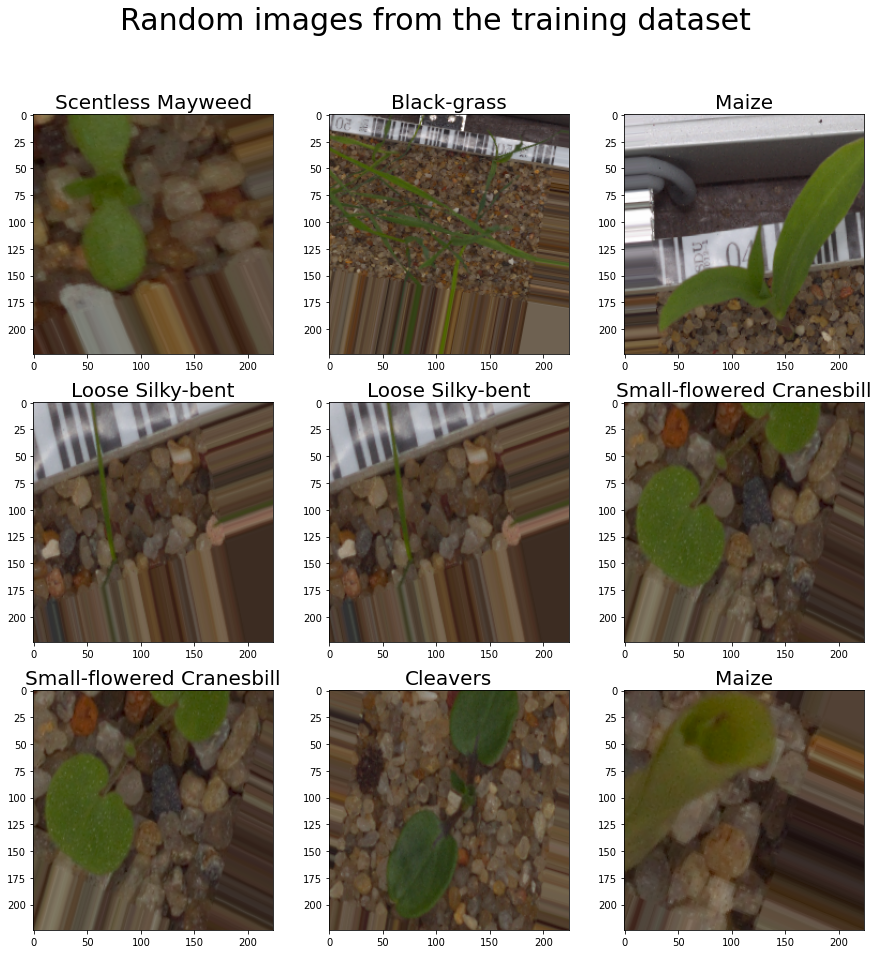

In [17]:
### Plot some random images from the training data set set along with their class labels

# Generate a batch of data from the training set
X_train, y_train = next(train_generator)

# Plot four random images from the batch
fig = plt.figure(figsize = (15, 15))
fig.suptitle('Random images from the training dataset', fontsize = 30)

# Generate four random sample indices from the batch.
samp_index = np.random.randint(low = 0, high = mod_bat_size, size = 9).tolist()

for ind, value in enumerate(samp_index):

    # Extract image and label from batch
    img = X_train[value].copy()
    label = np.argmax(y_train[value])
    
    # Undo pre-processing of image
    if ((bm_name == 'VGG16') or (bm_name == 'ResNet50')):
        mean = [103.939, 116.779, 123.68]
        img[..., 0] += mean[0]
        img[..., 1] += mean[1]
        img[..., 2] += mean[2]
        img = img[..., ::-1].astype('uint8')
    elif ((bm_name == 'MobileNet') or (bm_name == 'InceptionV3')):
        img = ((img + 1) * 127.5).astype('uint8')

    # Plot image
    ax = plt.subplot(3, 3, (ind + 1))
    ax.imshow(img.astype('uint8'))
    ax.set_title("%s" %(class_map[label]), fontsize = 20)

#plt.tight_layout()
plt.show()

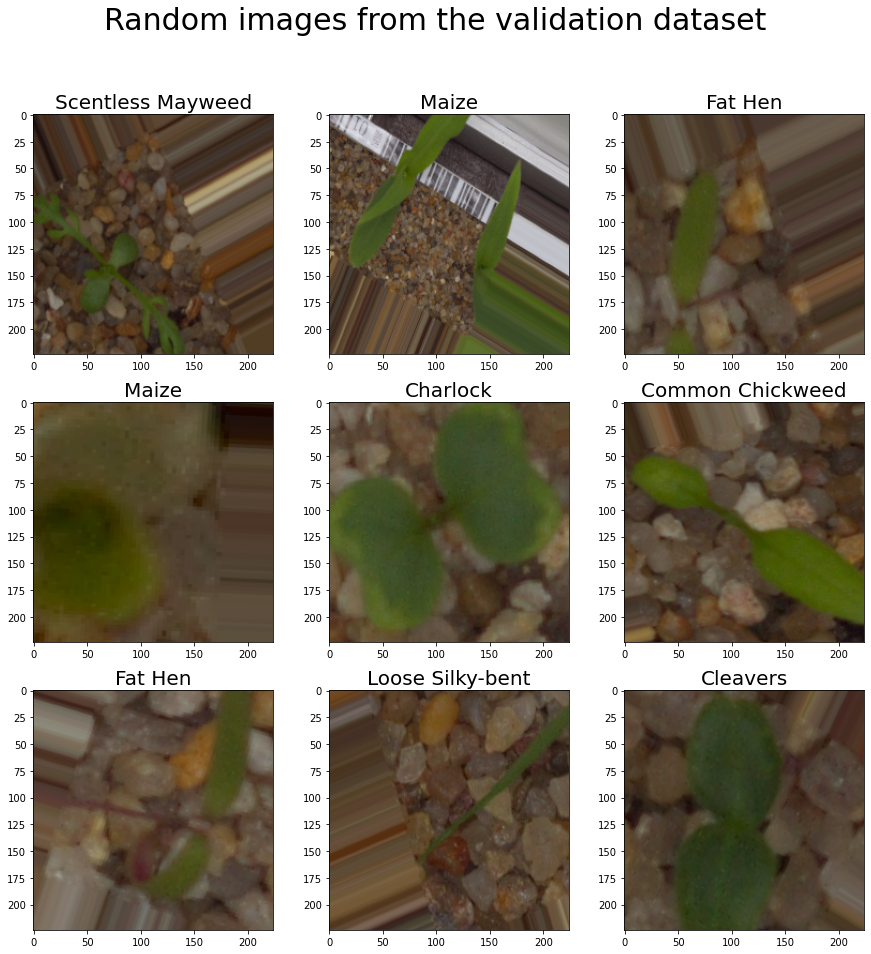

In [18]:
### Plot some random images from the validation data set set along with their class labels

# Generate a batch of data from the training set
X_val, y_val = next(val_generator)

# Plot four random images from the batch
fig = plt.figure(figsize = (15, 15))
fig.suptitle('Random images from the validation dataset', fontsize = 30)

# Generate four random sample indices from the batch.
samp_index = np.random.randint(low = 0, high = mod_bat_size, size = 9).tolist()

for ind, value in enumerate(samp_index):

    # Extract image and label from batch
    img = X_val[value].copy()
    label = np.argmax(y_val[value])
    
    # Undo pre-processing of image
    if ((bm_name == 'VGG16') or (bm_name == 'ResNet50')):
        mean = [103.939, 116.779, 123.68]
        img[..., 0] += mean[0]
        img[..., 1] += mean[1]
        img[..., 2] += mean[2]
        img = img[..., ::-1].astype('uint8')
    elif ((bm_name == 'MobileNet') or (bm_name == 'InceptionV3')):
        img = ((img + 1) * 127.5).astype('uint8')

    # Plot image
    ax = plt.subplot(3, 3, (ind + 1))
    ax.imshow(img.astype('uint8'))
    ax.set_title("%s" %(class_map[label]), fontsize = 20)

#plt.tight_layout()
plt.show()

# Supervised Learning Classifiers
In this section, we will train two supervised learning classifiers (SVM and XGBoost) and evaluate performance with these models

## Generate input and output for supervised learning model

In [19]:
# Get list of folders (classes in train dataset path)
seedling_class_list = sorted(os.listdir(train_set_path))

# Get number of images in training set path 
num_train_images =  sum(len(files) for _, _, files in os.walk(train_set_path))

# Create empty arrays to store training images and corresponding labels
train_img_array = np.zeros((num_train_images, 100, 100, 3))
train_img_class = np.zeros((num_train_images))

# Populate images and labels in the above arrays
# Images are imported as color images with target size of (100, 100)
arr_ind = 0
for cl_ind, cl_val in enumerate(tqdm(seedling_class_list)):
    file_list = sorted(os.listdir(os.path.join(train_set_path, cl_val)))
    for fi_ind, fi_val in enumerate(file_list):
        file_path = os.path.join(train_set_path, cl_val, fi_val)
        train_img = load_img(file_path, color_mode = "rgb", target_size = (100, 100))
        train_img = img_to_array(train_img)
        train_img_array[arr_ind], train_img_class[arr_ind] = train_img, cl_ind
        arr_ind += 1

print("\n",train_img_array.shape)
print(train_img_class.shape)

100%|██████████| 12/12 [00:47<00:00,  3.92s/it]


 (4767, 100, 100, 3)
(4767,)


In [20]:
X = train_img_array.copy() 
y = train_img_class.copy()
X = np.reshape(X, (X.shape[0], -1)) # Flatten input image array

del train_img_array
del train_img_class

print("Shape of training set input is {}" .format(X.shape))
print("Shape of training set labels is {}" .format(y.shape))

Shape of training set input is (4767, 30000)
Shape of training set labels is (4767,)


## Perform PCA

We will now perform PCA on this data to see how many components are needed to explain the variance in the data.

In [21]:
# # Start with number of principal components = number of features.
tot_num_pc = X.shape[0]
# Create pipeline with Standard Scaler and PCA with number of components = number of features.
pipe_pca = make_pipeline(StandardScaler(), PCA(n_components = tot_num_pc), verbose = 2)
# Fit PCA on the input feature set.
pipe_pca.fit(X)

# fname = 'pca.pkl' # Name of file to store CV results
# with open(os.path.join(out_base_path, fname), 'wb') as fobj:
#     pickle.dump(pipe_pca, fobj)

[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   3.2s
[Pipeline] ............... (step 2 of 2) Processing pca, total= 3.6min


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=4767,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=2)

The number of principal components required to explain 95% of the variance in the input data is 1445
The number of principal components required to explain 99% of the variance in the input data is 2817


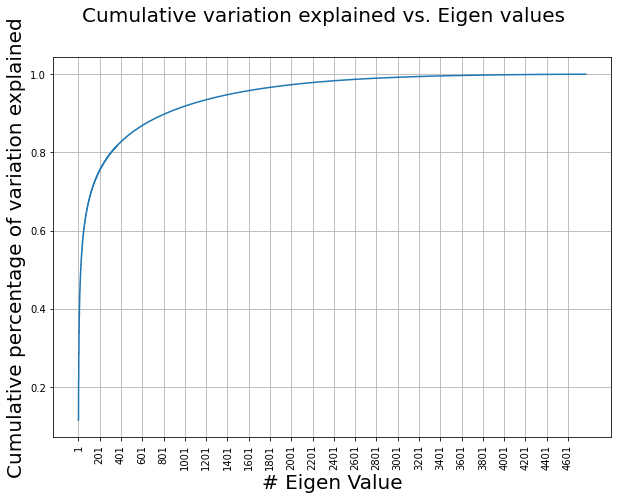

In [22]:
# fname = 'pca.pkl' # Name of file to store CV results
# with open(os.path.join(out_base_path, fname), 'rb') as fobj:
#     pipe_pca = pickle.load(fobj)

# Calculate cumulative sum of explained variance ratio
exp_var_rat = pipe_pca.named_steps['pca'].explained_variance_ratio_
cum_sum_exp_var_rat = np.cumsum(exp_var_rat)

# Find number of principal components needed to explain 95% of the variance
num_pc_95per = np.where(cum_sum_exp_var_rat > 0.95)[0][0] + 1
num_pc_99per = np.where(cum_sum_exp_var_rat > 0.99)[0][0] + 1
print("The number of principal components required to explain 95%% of the variance \
in the input data is %d" % num_pc_95per)
print("The number of principal components required to explain 99%% of the variance \
in the input data is %d" % num_pc_99per)

fig = plt.figure(figsize = (10, 7))
fig.suptitle('Cumulative variation explained vs. Eigen values', fontsize = 20)
plt.step(list(range(1, (tot_num_pc + 1))), cum_sum_exp_var_rat, where = 'mid')
plt.ylabel('Cumulative percentage of variation explained', fontsize = 20)
plt.xlabel('# Eigen Value', fontsize = 20)
plt.xticks(ticks = list(range(1, (tot_num_pc + 1), 200)), rotation = 90)
plt.grid(True)
plt.show()

<b>The above plot shows that 2817 components are sufficient to explain 99% of the variance in the input data. In the next section, a compressed version of the input dataset is generated with 3000 PCA components. Since this step takes a long time to run, it is commented out in the code below.</b>

In [23]:
### This section is commented out.

# # Generate a compressed version of the input image array 
# # by performing PCA with 3000 components
# pipe_steps = [('scal', StandardScaler()), ('pca', PCA(n_components = 3000))]
# pipe = Pipeline(pipe_steps, verbose = 2)
# X_red = pipe.fit_transform(X)
# print("\nShape of original input image array is {}" .format(X.shape))
# print("Shape of PCA transformed input image array is {}" .format(X_red.shape))

## Evaluate SVM classifier

### Original dataset (no PCA)

In [24]:
# Create pipeline of MinMaxScaler and SVM with default settings
# RBF kernel, gamma = 'scale', C = 1.0
pipe = make_pipeline(MinMaxScaler(), SVC()) 

##### This section is commented out. Results will be loaded directly from file below

# # Run 2-fold CV on original dataset
# start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
# print("Fitting Classifier.... Started at %s" %(start_time.strftime("%H:%M:%S")), end = '; ')

# cv_results = cross_validate(pipe, X, y, cv = 2, n_jobs = -1, verbose = 0, return_train_score = True) 

# end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
# elap_time = ((end_time - start_time).total_seconds())/60
# print("Completed at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time)) 

# fname = 'cvr_svc_full_dset.pkl' # Name of file to store CV results
# with open(os.path.join(out_base_path, fname), 'wb') as fobj:
#     pickle.dump(cv_results, fobj)

##### This section is commented out. Results will be loaded directly from file below    

In [25]:
fname = 'cvr_svc_full_dset.pkl' # Name of file to read CV results
with open(os.path.join(out_base_path, fname), 'rb') as fobj:
    cv_results = pickle.load(fobj)
print("Mean cross-validation accuracy is %0.1f %%" %(100 * cv_results['test_score'].mean()))
print("Mean training set accuracy is %0.1f %%" %(100 * cv_results['train_score'].mean()))

Mean cross-validation accuracy is 45.8 %
Mean training set accuracy is 84.8 %


<b>As seen above, cross-validation performance of the SVM classifier is very poor.</b>

### Reduced dataset (with PCA)

In [26]:
# Create pipeline of MinMaxScaler and SVM with default settings
# RBF kernel, gamma = 'scale', C = 1.0
pipe = make_pipeline(MinMaxScaler(), SVC()) 

##### This section is commented out. Results will be loaded directly from file below

# # Run 2-fold CV on original dataset
# start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
# print("Fitting Classifier.... Started at %s" %(start_time.strftime("%H:%M:%S")), end = '; ')

# cv_results = cross_validate(pipe, X_red, y, cv = 2, n_jobs = -1, verbose = 0, return_train_score = True) 

# end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
# elap_time = ((end_time - start_time).total_seconds())/60
# print("Completed at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time)) 

# fname = 'cvr_svc_red_dset.pkl' # Name of file to store CV results
# with open(os.path.join(out_base_path, fname), 'wb') as fobj:
#     pickle.dump(cv_results, fobj)

##### This section is commented out. Results will be loaded directly from file below    

In [27]:
fname = 'cvr_svc_red_dset.pkl' # Name of file to read CV results
with open(os.path.join(out_base_path, fname), 'rb') as fobj:
    cv_results = pickle.load(fobj)
print("Mean cross-validation accuracy is %0.1f %%" %(100 * cv_results['test_score'].mean()))
print("Mean training set accuracy is %0.1f %%" %(100 * cv_results['train_score'].mean()))

Mean cross-validation accuracy is 19.6 %
Mean training set accuracy is 86.7 %


<b>With the reduced dataset (compressed through PCA), cross-validation performance of the SVM classifier is even poorer. Even though PCA tries to capture most of the variance in the data, it may not be able to capture all the nonlinearities of an image, invariance to translation, lighting etc. Hence training the classifier with the compressed input data doesn't give very good performance.</b>

### Hyperparameter tuning

<b>Random search over the following range:</b>
  * C = loguniform(0.1, 10)
  * gamma = loguniform(1e-4, 1e-2)

In [28]:
param_grid = {'clf__C': loguniform(0.1, 10),
              'clf__gamma': loguniform(1e-4, 1e-2)
             }
pipe_steps = [('scal', MinMaxScaler()), ('clf', SVC())]
pipe = Pipeline(pipe_steps, verbose = 0)   
rands = RandomizedSearchCV(pipe, param_grid, n_iter = 10, cv = 2, n_jobs = -1, verbose = 3,\
                           return_train_score = True, refit = False)

##### This section is commented out. Results will be loaded directly from file below

# start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
# print("Starting random search.... Started at %s" %(start_time.strftime("%H:%M:%S")), end = '; ')

# rands.fit(X, y)

# end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
# elap_time = ((end_time - start_time).total_seconds())/60
# print("Completed at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time)) 

# fname = 'rands_svc_full_dset_2.joblib' # Name of file to store random search results
# dump(rands, os.path.join(out_base_path, fname)) 

##### This section is commented out. Results will be loaded directly from file below

In [29]:
fname = 'rands_svc_full_dset_1.joblib' # Name of file to load random search results from
rands = load(os.path.join(out_base_path, fname)) # Load random search object from joblib file
# Obtain index corresponding to best CV score
best_res_ind = np.argmin(rands.cv_results_['rank_test_score']) 
print("Best Value of C is %0.4f" %(rands.cv_results_['param_clf__C'][best_res_ind]))
print("Best Value of gamma is %0.4f" %(rands.cv_results_['param_clf__gamma'][best_res_ind]))
print("Best cross-validataion score is %0.1f %%"\
      %(100 * (rands.cv_results_['mean_test_score'][best_res_ind])))

Best Value of C is 4.5325
Best Value of gamma is 0.0014
Best cross-validataion score is 51.1 %


<b>Finer random search:</b>
  * C = loguniform(5, 100)
  * gamma = loguniform(1e-3, 1e-1)

In [30]:
fname = 'rands_svc_full_dset_2.joblib' # Name of file to load random search results from
rands = load(os.path.join(out_base_path, fname)) # Load random search object from joblib file
# Obtain index corresponding to best CV score
best_res_ind = np.argmin(rands.cv_results_['rank_test_score']) 
print("Best Value of C is %0.4f" %(rands.cv_results_['param_clf__C'][best_res_ind]))
print("Best Value of gamma is %0.4f" %(rands.cv_results_['param_clf__gamma'][best_res_ind]))
print("Best cross-validataion score is %0.1f %%"\
      %(100 * (rands.cv_results_['mean_test_score'][best_res_ind])))

Best Value of C is 22.7903
Best Value of gamma is 0.0014
Best cross-validataion score is 50.8 %


<b>After hyperparameter tuning, cross-validation score has improved to around 51% but is still very low.</b>

## Evaluate XGBOOST classifier

### Original dataset (no PCA)

In [31]:
# Create XGBoost classifier instance
clf = XGBClassifier(n_estimators = 200, verbosity = 0)

##### This section is commented out. Results will be loaded directly from file below

# # Run 2-fold CV on original dataset
# start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
# print("Fitting Classifier.... Started at %s" %(start_time.strftime("%H:%M:%S")), end = '; ')

# cv_results = cross_validate(clf, X, y, cv = 2, n_jobs = -1, verbose = 0, return_train_score = True) 

# end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
# elap_time = ((end_time - start_time).total_seconds())/60
# print("Completed at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time)) 

# fname = 'XGBC_n_est_200_full_dset.pkl' # Name of file to store CV results
# with open(os.path.join(out_base_path, fname), 'wb') as fobj:
#     pickle.dump(cv_results, fobj)

##### This section is commented out. Results will be loaded directly from file below    

In [32]:
fname = 'XGBC_n_est_200_full_dset.pkl' # Name of file to read CV results
with open(os.path.join(out_base_path, fname), 'rb') as fobj:
    cv_results = pickle.load(fobj)
print("Mean cross-validation accuracy is %0.1f %%" %(100 * cv_results['test_score'].mean()))
print("Mean training set accuracy is %0.1f %%" %(100 * cv_results['train_score'].mean()))

Mean cross-validation accuracy is 59.2 %
Mean training set accuracy is 100.0 %


<b>Results with the XGB classifier are better but CV accuracy is still only 60%. Lets start evaluating neural network architectures next.</b>

# Neural Network Architectures

## Function - Convolution core

In [33]:
def conv_core(X, nc, fs, ks, pad, sn):

    """
    Function to implement a general conv-maxpool section
    
    Arguments:
        X - input tensor
        nc - Number of convolution layers to use before maxpool
        fs - Filter size to use for each conv. layer
        ks - tuple indicating size of kernel to use for each conv. layer
        pad - padding type for each conv. layer
        sn - Section name 

    Returns:
        Y - Output of section
 
    """ 

    for ind in list(range(nc)):
        X = Conv2D(filters = fs, kernel_size = ks, padding = pad, activation = 'relu',\
                   name = ('C2D_' + sn + str((ind+1))))(X)
    Y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid',\
                     name = ('MXP_' + sn))(X)

    return Y

### Verify convolution core section

In [34]:
tm1_inp = Input(shape = mod_inp_shape, name = 'IL')
tm1_out = conv_core(tm1_inp, nc = 2, fs = 64, ks = (3, 3), pad = 'same', sn = 'A')
tm1 = Model(tm1_inp, tm1_out)
tm1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IL (InputLayer)              [(None, 224, 224, 3)]     0         
_________________________________________________________________
C2D_A1 (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
C2D_A2 (Conv2D)              (None, 224, 224, 64)      36928     
_________________________________________________________________
MXP_A (MaxPooling2D)         (None, 112, 112, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


## Function - VGG16 core

In [35]:
def vgg16_core(X, num_classes):

    """
    Function to define the convolutional section core of custom vgg16 model
    
    Arguments:
        X - input tensor of shape (224, 224, 3)
        num_classes - Number of output classes (no. of units for last softmax layer)

    Returns:
        Y - Output of last FC layer
 
    """ 

    Y = conv_core(X, nc = 2, fs = 64, ks = (3, 3), pad = 'same', sn = 'A') # First section
    Y = conv_core(Y, nc = 2, fs = 128, ks = (3, 3), pad = 'same', sn = 'B') # Second section    
    Y = conv_core(Y, nc = 3, fs = 256, ks = (3, 3), pad = 'same', sn = 'C') # Third section
    Y = Dropout(rate = 0.5, name = "DR1")(Y) # Dropout layer           
    Y = conv_core(Y, nc = 3, fs = 512, ks = (3, 3), pad = 'same', sn = 'D') # Fourth section  
    Y = conv_core(Y, nc = 3, fs = 512, ks = (3, 3), pad = 'same', sn = 'E') # Fifth section
    Y = GlobalAveragePooling2D()(Y) # Global Average Pooling
    Y = Dropout(rate = 0.5, name = "DR2")(Y) # Dropout layer       
    Y = Dense(1024, activation = 'relu', name = "D1")(Y) # First dense layer
    Y = Dense(512, activation = 'relu', name = "D3")(Y) # Second dense layer
    Y = Dense(num_classes, activation = 'softmax', name = "OL")(Y) # Output layer

    return Y

### Verify VGG16 core

In [36]:
tm2_inp = Input(shape = mod_inp_shape, name = 'IL')
tm2_out = vgg16_core(tm2_inp, num_classes)
tm2 = Model(tm2_inp, tm2_out)
tm2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IL (InputLayer)              [(None, 224, 224, 3)]     0         
_________________________________________________________________
C2D_A1 (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
C2D_A2 (Conv2D)              (None, 224, 224, 64)      36928     
_________________________________________________________________
MXP_A (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
C2D_B1 (Conv2D)              (None, 112, 112, 128)     73856     
_________________________________________________________________
C2D_B2 (Conv2D)              (None, 112, 112, 128)     147584    
_________________________________________________________________
MXP_B (MaxPooling2D)         (None, 56, 56, 128)       0   

## Function - Define Model Core

In [37]:
def model_core(model_dict):
    
    """
    Function to define the model core.
    
    Arguments:
        model_dict - Dictionary with list of keys / values needed to build the model

    Returns:
        model - Model with all layers instantiated
 
    """    
    # Retrieve model dict parameters
    model_arch = model_dict['model_arch'] # Model architecture to use
    inp_shape = model_dict['inp_shape'] # Shape of input to model
    num_hid_lay = model_dict['num_hid_lay'] # Number of hidden layers to use for a dense NN
    hidden_nodes = model_dict['hidden_nodes'] # Number of hidden nodes to use for each layer
    l2_val = model_dict['l2_val'] # L2-regularization to use for each layer
    use_bnorm = model_dict['use_bnorm'] # Boolean: If true, use BatchNormalization layer after 
                                        # each hidden dense layer
    use_dropout = model_dict['use_dropout'] # Boolean: If true, use Dropout layer after 
                                            # each hidden dense layer
    dropout_rate = model_dict['dropout_rate'] # Dropout rate to use for each layer
    output_nodes = model_dict['output_nodes'] # Number of output nodes to use for the final softmax layer
    bm_weights = model_dict['bm_weights'] # Base model weights to use
    bm_layers_nontrain = model_dict['bm_layers_nontrain'] # Base model layers to set as non-trainable                                             

    ##### Start Model Architecture A (Dense Neural Network Architecture)

    if (model_arch == 'A'):

        model = Sequential() # Instantiate Sequential model
        model.add(Input(shape = inp_shape, name = "INP_LAY")) # Add Input layer
        model.add(Flatten(name = "FLAT_LAY")) # Add Flatten layer

        # Add hidden layers
        for lay in range(num_hid_lay):
            model.add(Dense(hidden_nodes[lay], kernel_initializer = HeNormal(seed = 0),\
                            kernel_regularizer = l2(l2 = l2_val[lay]),\
                            name = ("HID_LAY_" + str((lay+1))))) # Add hidden layer
             
            if (use_bnorm): # Add BatchNormalization layer
                model.add(BatchNormalization(axis = -1, name = ("BN_LAY_" + str((lay+1)))))
            
            model.add(Activation('relu', name = ("ACT_" + str((lay+1))))) # Add ReLU activation layer

            if (use_dropout): # Add Dropout layer
                model.add(Dropout(rate = dropout_rate[lay], name = ("DROP_" + str((lay+1)))))

        # Add output softmax layer
        model.add(Dense(output_nodes, activation = 'softmax', kernel_initializer = HeNormal(seed = 0),\
                        kernel_regularizer = l2(l2 = l2_val[num_hid_lay]),\
                        name = "OUT_LAY")) # Add output layer

    ##### End Model Architecture A    

    ##### Start Model Architecture B (Custom VGG16 model architecture)

    if (model_arch == 'B'):

        # Define overall model (funtional model)
        inputs = Input(shape = inp_shape, name = 'IL') # Instantiate input layer
        outputs = vgg16_core(inputs, output_nodes) # Instantiate VGG16 core
        model = Model(inputs, outputs)

    ##### End Model Architecture B           

    ##### Start Model Architecture C (Transfer Learning architectures)

    if (model_arch == 'C'):

        if (bm_name == 'VGG16'):
            # Define base model
            base_model = vgg16.VGG16(input_shape = inp_shape, weights = bm_weights,\
                                     include_top = False, pooling = 'avg')
        if (bm_name == 'ResNet50'):
            # Define base model
            base_model = resnet50.ResNet50(input_shape = inp_shape, weights = bm_weights,\
                                           include_top = False, pooling = 'avg')
        if (bm_name == 'MobileNet'):
            # Define base model
            base_model = mobilenet.MobileNet(input_shape = inp_shape, alpha = 1.0, weights = bm_weights,\
                                             include_top = False, pooling = 'avg')
        if (bm_name == 'InceptionV3'):
            # Define base model
            base_model = inception_v3.InceptionV3(input_shape = inp_shape, weights = bm_weights,\
                                                  include_top = False, pooling = 'avg') 
        for layers in base_model.layers[:bm_layers_nontrain]:
            layers.trainable = False
        
        # Define overall model (funtional model)
        X = base_model.output
        # X = Flatten()(X) # Flatten layer
        X = Dropout(rate = 0.5, name = "DR1")(X) # Dropout layer           
        X = Dense(1024, activation = 'relu', name = "D1")(X) # Dense layer
        # X = Dropout(rate = 0.3, name = "DR2")(X) # Dropout layer
        X = Dense(512, activation = 'relu', name = "D2")(X) # Dnse layer
        # X = Dropout(rate = 0.5, name = "DR3")(X) # Dropout layer
        outputs = Dense(output_nodes, activation = 'softmax', name = "OL")(X) # Output layer

        model = Model(base_model.inputs, outputs)

    ##### End Model Architecture C           

    return model

### Verify Model Core function

In [38]:
# Verify model defined above
model_dict = {'model_arch': 'B',
              'inp_shape': mod_inp_shape, # Shape of input to model
              'num_hid_lay': 4, # Number of hidden layers to use for a dense NN
              'hidden_nodes': [256, 256, 128, 128], # Number of hidden nodes to use for each layer
              'l2_val': [0, 0, 0, 0, 0], # L2-regularization to use for each layer
              'use_bnorm': True, # Boolean: If true, use BatchNormalization layer after 
                                  # each hidden dense layer
              'use_dropout': False, # Boolean: If true, use Dropout layer after 
                                    # each hidden dense layer
              'dropout_rate': [0, 0, 0, 0], # Dropout rate to use for each layer
              'output_nodes': num_classes, # Number of output nodes to use for the final softmax layer
              'bm_weights': 'imagenet', # Base model weights to use
              'bm_layers_nontrain': -11 # Base model layers to set as non-trainable
              }
temp_model = model_core(model_dict)
temp_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IL (InputLayer)              [(None, 224, 224, 3)]     0         
_________________________________________________________________
C2D_A1 (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
C2D_A2 (Conv2D)              (None, 224, 224, 64)      36928     
_________________________________________________________________
MXP_A (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
C2D_B1 (Conv2D)              (None, 112, 112, 128)     73856     
_________________________________________________________________
C2D_B2 (Conv2D)              (None, 112, 112, 128)     147584    
_________________________________________________________________
MXP_B (MaxPooling2D)         (None, 56, 56, 128)       0   

## Function - Define model compile, train and eval

In [39]:
def model_comp_fit_eval(model_dict, train_dict, model = None):
    
    """
    Function to compile, fit and evaluate model. 
    
    Arguments:
    model_dict - Dictionary with list of keys / values needed to build the model
               - See function model_core for more details
    train_dict - Dictionary with list of keys / values needed to compile and train the model
      'epochs': Number of epochs to train for
      'batch_size': Size of each training batch      
      'steps_per_epoch': Number of steps per epoch
      'val_steps': Number of steps before stopping validation
      'early_stop': Boolean: If True, implement early stop
      'redlr_plat': Boolean: If True, implement reduce learning rate plateau      
      'ilr': Initial learning rate to use for learning rate decay scheduler
      'dr': Decay rate to use for learning rate decay scheduler
      'ds': Decay step to use for learning rate decay scheduler
      'lrpl_fac': Factor to use for Reduce LR on Plateau callback
      'lrpl_pat': Patience to use for Reduce LR on Plateau callback
      'verb': Boolean: If True, print running summary during model fit.
      'mcp_freq': Number of batches after which model will be checkpointed
      'tb_path': Path to store Tensorboard callback information
      'mc_path': File name to use for storing model checkpoints
      'fm_path': File name to use for storing final trained model
      'hi_path': File name to use for storing training history
    model - Model instance that has already been compiled and trained (to use for resuming fit)      

    Returns:
    model - Model instance with trained weights
    hist - Training history object 

    """      
    # Retrieve train_dict parameters
    epochs = train_dict['epochs'] # Number of epochs to train for
    batch_size = train_dict['batch_size'] # Size of each training batch    
    initial_epoch = train_dict['initial_epoch'] # Initial epoch to re-start training from
    fit_resume = train_dict['fit_resume'] # Boolean: If True, resume fit from initial epoch
    load_model = train_dict['load_model'] # Boolean: If True, load model from fm_path and resume fit
    recompile = train_dict['recompile'] # Boolen: If True, recompile model before resuming fit
    steps_per_epoch = train_dict['steps_per_epoch'] # Number of steps per epoch
    val_steps = train_dict['val_steps'] # Number of steps before stopping validation
    early_stop = train_dict['early_stop'] # Boolean: If True, implement early stop
    ilr = train_dict['ilr'] # Initial learning rate to use for learning rate decay scheduler
    redlr_plat = train_dict['redlr_plat'] # Boolean: If True, implement reduce learning rate plateau    
    dr = train_dict['dr'] # Decay rate to use for learning rate decay scheduler
    ds = train_dict['ds'] # Decay step to use for learning rate decay scheduler
    lrpl_fac = train_dict['lrpl_fac'] # Factor to use for Reduce LR on Plateau callback
    lrpl_pat = train_dict['lrpl_pat'] # Patience to use for Reduce LR on Plateau callback    
    verb = train_dict['verb'] # Boolean: If True, print running summary during model fit.
    mcp_freq = train_dict['mcp_freq'] # Number of batches after which model will be checkpointed
    tb_path = train_dict['tb_path'] # Path to store Tensorboard callback information
    mc_path = train_dict['mc_path'] # File name to use for storing model checkpoints
    fm_path = train_dict['fm_path'] # File name to use for storing final trained model
    hi_path = train_dict['hi_path'] # File name to use for storing training history

    ### Start definitions

    # Define learning rate decay schedule
    lr_sch = InverseTimeDecay(ilr, ds, dr)

    # Define Optimizer
    if (redlr_plat):
      opt = optimizers.Adam(learning_rate = ilr) 
    else:
      opt = optimizers.Adam(learning_rate = lr_sch)
    
    # Define Loss:
    loss = losses.CategoricalCrossentropy()
    
    # Define Metric
    met = [metrics.CategoricalAccuracy()]
    
    # Define path for tensorboard logs
    logdir = os.path.join(tb_path,\
                          datetime.datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d%m_%H%M"))
    # Define Tensorboard callback
    tensorboard_callback = TensorBoard(logdir, histogram_freq = 0)
    
    # Define Model Checkpoint callback
    mcp_callback = ModelCheckpoint(filepath = mc_path, monitor = "val_loss", save_best_only = False,\
                                   save_weights_only = False, mode = "min",\
                                   save_freq = mcp_freq, verbose = 0)

    # Define Early Stopping callback
    earlystopping_callback = EarlyStopping(monitor = "loss", min_delta = 1e-4, patience = 10,\
                                           mode = "min", verbose = 1)
    
    # Define 'Reduce learning rate on plateau' callback
    redlr_plat_callback = ReduceLROnPlateau(monitor = "val_loss", factor = lrpl_fac, patience = lrpl_pat,\
                                            verbose = 1, mode = "min", min_delta = 0.0001)

    # Define list of all callbacks
    callback_list = []
    if (redlr_plat):
        callback_list.append(redlr_plat_callback)
    if (early_stop):
        callback_list.append(earlystopping_callback)
    if (tb_path != 'None'):
        callback_list.append(tensorboard_callback)
    if (mc_path != 'None'):
        callback_list.append(mcp_callback)

    ### End definitions
    
    ### Start model instantiation

    if (not(fit_resume)):
        # Instantiate new model instance
        print("Instantiating new model...", end = ', ')
        model = model_core(model_dict)
      
    if ((fit_resume and load_model)):
        print("Reloading model from disk...", end = ', ')
        model = models.load_model(fm_path)

    ### End model instantiation

    # Compile model
    if ((not(fit_resume) or recompile)):
        print("Compiling model...", end = ', ')
        model.compile(optimizer = opt, loss = loss, metrics = met)
    
    # Fit model
    if (fit_resume):
        print("Resuming model fit.... ", end = ', ')
    else:
        print("Model Fit started....", end = ', ')

    hist = model.fit(x = train_generator, epochs = epochs, initial_epoch = initial_epoch,\
                     steps_per_epoch = steps_per_epoch, validation_data = val_generator,\
                     validation_steps = val_steps, verbose = verb, callbacks = callback_list,\
                     validation_freq = 10)
        
    # Save final trained model to file
    if (fm_path != 'None'):
      # Save final trained model in Keras HDF5 format
      model.save(fm_path, overwrite = True, save_format = 'h5') 
    if (hi_path != 'None'):
      # Save training history to file
      np.save(hi_path, hist.history)
    
    return model, hist

## Launch Tensorboard

In [40]:
### This section is commented out in the final code

# %tensorboard --logdir {tb_logs_base_dir}
# %tensorboard --logdir {tb_logs_base_dir}

## Set all model, compile and training parameters

This section is used to set all the parameters required for each training run

In [41]:
### Define file paths
# Prefix to use for naming files and paths
mod_file_pref = "MB_1" 
# Tensorboard base path
tb_path = os.path.join(tb_logs_base_dir, mod_file_pref) 
# Path for storing final trained model
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") 
# Path for storing model checkpoints
mc_path = os.path.join(out_base_path, mod_file_pref + "_EP{epoch:04d}.h5")
# Path for storing training history
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy")

# Define model_dict and train_dict
model_dict = {'model_arch': 'B',
              'inp_shape': mod_inp_shape, # Shape of input to model
              'num_hid_lay': 4, # Number of hidden layers to use for a dense NN
              'hidden_nodes': [256, 256, 128, 128], # Number of hidden nodes to use for each layer
              'l2_val': [0, 0, 0, 0, 0], # L2-regularization to use for each layer
              'use_bnorm': True, # Boolean: If true, use BatchNormalization layer after 
                                  # each hidden dense layer
              'use_dropout': False, # Boolean: If true, use Dropout layer after 
                                    # each hidden dense layer
              'dropout_rate': [0, 0, 0, 0], # Dropout rate to use for each layer
              'output_nodes': num_classes, # Number of output nodes to use for the final softmax layer
              'bm_weights': 'imagenet', # Base model weights to use
              'bm_layers_nontrain': -11 # Base model layers to set as non-trainable
              }
train_dict = {'epochs': 150, # Number of epochs to train for
              'batch_size': mod_bat_size, # Batch size for each training step
              'initial_epoch': 0, # Initial epoch to start from
              'fit_resume': False, # Boolean: If True, resume fit from initial epoch
              'load_model': False, # Boolean: If True, load model from fm_path and resume fit
              'recompile': False, # Boolen: If True, recompile model before resuming fit
              'steps_per_epoch': (train_generator.__len__()), # No. of steps per epoch
              'val_steps': (val_generator.__len__()), # No. of steps before stopping val
              'early_stop': False, # Boolean: If True, implement early stop
              'redlr_plat': False, # Boolean: If True, implement reduce learning rate plateau
              'ilr': 1e-4, # Initial learning rate to use for learning rate decay scheduler
              'dr': 1, # Decay rate to use for learning rate decay scheduler
              'ds': (train_generator.__len__() * 50), # Decay step to use for lr decay
              'lrpl_fac': 0.5, # Factor to use for Reduce LR on Plateau callback
              'lrpl_pat': 10, # Patience to use for Reduce LR on Plateau callback              
              'verb': 1, # Boolean: If True, print running summary during model fit.
              'mcp_freq': (train_generator.__len__() * 25), # Number of batches after 
                                                            # which model will be checkpointed
              'tb_path': tb_path, # Path to store Tensorboard callback information
              'mc_path': mc_path, # File name to use for storing model checkpoints
              'fm_path': fm_path, # File name to use for storing final trained model
              'hi_path': hi_path, # File name to use for storing training history
              }

print(tb_path)
print(mc_path)
print(fm_path)
print(hi_path)

/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Plant_Seedling_Classification/TB_Logs/MB_1
/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Plant_Seedling_Classification/Training_Info/MB_1_EP{epoch:04d}.h5
/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Plant_Seedling_Classification/Training_Info/MB_1_finalmodel.h5
/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Plant_Seedling_Classification/Training_Info/MB_1_hist.npy


### Verify model instantiation, loss and compile options

In [42]:
# Verify model instantiation, loss and compile options
train_dict_temp = {'epochs': 0, # Number of epochs to train for
              'batch_size': mod_bat_size, # Batch size for each training step
              'initial_epoch': 0, # Initial epoch to start from
              'fit_resume': False, # Boolean: If True, resume fit from initial epoch
              'load_model': False, # Boolean: If True, load model from fm_path and resume fit
              'recompile': False, # Boolen: If True, recompile model before resuming fit
              'steps_per_epoch': (train_generator.__len__()), # No. of steps per epoch
              'val_steps': (val_generator.__len__()), # No. of steps before stopping val
              'early_stop': False, # Boolean: If True, implement early stop
              'redlr_plat': False, # Boolean: If True, implement reduce learning rate plateau
              'ilr': 1e-4, # Initial learning rate to use for learning rate decay scheduler
              'dr': 0, # Decay rate to use for learning rate decay scheduler
              'ds': (train_generator.__len__() * 10), # Decay step to use for lr decay
              'lrpl_fac': 0.5, # Factor to use for Reduce LR on Plateau callback
              'lrpl_pat': 10, # Patience to use for Reduce LR on Plateau callback              
              'verb': 1, # Boolean: If True, print running summary during model fit.
              'mcp_freq': (train_generator.__len__() * 1), # Number of batches after 
                                                            # which model will be checkpointed
              'tb_path': 'None', # Path to store Tensorboard callback information
              'mc_path': 'None', # File name to use for storing best model checkpoint
              'fm_path': 'None', # File name to use for storing final trained model
              'hi_path': 'None', # File name to use for storing training history
              }


# temp_model, temp_hist = model_comp_fit_eval(model_dict, train_dict_temp)  

# print()
# display(temp_model.loss)
# print()
# display(temp_model.optimizer.get_config())
# print()
# display(temp_model.summary())

## Fit Model

This section is used to start the model training. It is commented out in this code since all the models have been trained and stored to disk.

In [43]:
# # Start model fit
# if (train_dict['fit_resume']):
#   start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
#   print("Started at %s" %(start_time.strftime("%H:%M:%S")), end = '; ')
#   model, hist = model_comp_fit_eval(model_dict, train_dict)
#   end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
#   elap_time = ((end_time - start_time).total_seconds())/60
#   print("\nCompleted at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time)) 
# else:
#   start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
#   print("Started at %s" %(start_time.strftime("%H:%M:%S")), end = '; ')
#   model, hist = model_comp_fit_eval(model_dict, train_dict)
#   end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
#   elap_time = ((end_time - start_time).total_seconds())/60
#   print("\nCompleted at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time)) 

# Summary of results

## Model - MA_1 - DNN_1

* Fully connected dense NN architecture 1:
  * Input image reshaped to (100, 100, 3)
  * Dense (256) -> BatchNorm -> ReLU
  * Dense (256) -> BatchNorm -> ReLU
  * Dense (128) -> BatchNorm -> ReLU
  * Dense (128) -> BatchNorm -> ReLU    
  * Dense(12, softmax)
* No image augmentation used. No dropout used.
* Optimizer = Adam, initial learning rate = 1e-2, decay rate = 1, decay steps = 20 epochs, trained for 100 epochs.
* Trainable parameters = 7.8M

### Define file paths

In [44]:
### Define file paths
mod_file_pref = "MA_1" 
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") 
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy")

# Load model with final trained weights
model = models.load_model(fm_path) 

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FLAT_LAY (Flatten)           (None, 30000)             0         
_________________________________________________________________
HID_LAY_1 (Dense)            (None, 256)               7680256   
_________________________________________________________________
BN_LAY_1 (BatchNormalization (None, 256)               1024      
_________________________________________________________________
ACT_1 (Activation)           (None, 256)               0         
_________________________________________________________________
HID_LAY_2 (Dense)            (None, 256)               65792     
_________________________________________________________________
BN_LAY_2 (BatchNormalization (None, 256)               1024      
_________________________________________________________________
ACT_2 (Activation)           (None, 256)              

### Create dataset for evaluation

In [45]:
bm_name = 'InceptionV3'
mod_inp_shape = (100, 100, 3) # Define target image size for model input
mod_bat_size = 32 # Batch size to use while model fitting

# Create train ImageDataGenerator objects without augmentation for evaluation purposes
# Same seed is used as earlier.
train_datagen_eval = ImageDataGenerator(validation_split = 0.25, preprocessing_function = preprocess_data)
train_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                              target_size = mod_inp_shape[:2],\
                                                              class_mode = 'categorical',\
                                                              batch_size = mod_bat_size, shuffle = True,\
                                                              subset = "training", seed = 1234)
val_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                            target_size = mod_inp_shape[:2],\
                                                            class_mode = 'categorical',\
                                                            batch_size = mod_bat_size, shuffle = True,\
                                                            subset = "validation", seed = 1234)

Found 3581 images belonging to 12 classes.
Found 1186 images belonging to 12 classes.


### Evaluate accuracy on train and val sets

In [46]:
### Evaluate model with final trained weights

# Evaluate model on training set
res = model.evaluate(x = train_generator_eval, verbose = 0, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on validation set
res = model.evaluate(x = val_generator_eval, verbose = 0, return_dict = True)
print("Validation set loss is %0.4f" % res['loss'])
print("Validation set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))

Training set loss is 1.2297
Training set accuracy is 82.21 %

Validation set loss is 3.6714
Validation set accuracy is 50.08 %


<b>This model achieves a training set accuracy of 82% and a validation set accuracy of 50% indicating huge overfitting of model.</b>

### Predict class of 'predict.png'

Predicted class is Common Chickweed
Prediction probability is 99.94 %


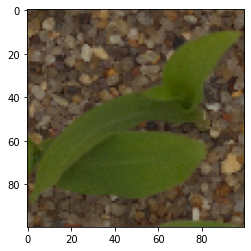

In [47]:
# Define path of prediction image file
pred_img_file_path = os.path.join(out_base_path, "Predict.png")
# Load image file in PIL format
pred_img = load_img(pred_img_file_path, target_size = mod_inp_shape[:2])
# Convert image file from PIL format to numpy array
pred_img_arr = img_to_array(pred_img)
pred_img_arr = np.expand_dims(pred_img_arr, axis = 0)
plt.imshow(pred_img_arr[0].astype('uint8'))

# Pre-process data with the correct pre-processing function
pred_img_arr_preproc = preprocess_data(pred_img_arr)
# Predict output class probabilities for prediction image file
pred_prob = model.predict(pred_img_arr_preproc)
pred_class = class_map[np.argmax(pred_prob)]

print("Predicted class is %s" %pred_class)
print("Prediction probability is %0.2f %%" %(100 * pred_prob[0, np.argmax(pred_prob)]))

<b>This model predicts the class of this image incorrectly.</b>

## Model - MA_2 - DNN_2

* Fully connected dense NN architecture 2:
  * Input image reshaped to (100, 100, 3)
  * Dense (256) -> BatchNorm -> ReLU
  * Dense (256) -> BatchNorm -> ReLU
  * Dense (128) -> BatchNorm -> ReLU
  * Dense (128) -> BatchNorm -> ReLU    
  * Dense(12, softmax)
* Full image augmentation used. No dropout used.
* Optimizer = Adam, initial learning rate = 1e-2, decay rate = 0, decay steps = 50 epochs, trained for 1000 epochs.
* Trainable parameters = 7.8M

### Define file paths

In [48]:
### Define file paths
mod_file_pref = "MA_2" 
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") 
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy")

# Load model with final trained weights
model = models.load_model(fm_path) 

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FLAT_LAY (Flatten)           (None, 30000)             0         
_________________________________________________________________
HID_LAY_1 (Dense)            (None, 256)               7680256   
_________________________________________________________________
BN_LAY_1 (BatchNormalization (None, 256)               1024      
_________________________________________________________________
ACT_1 (Activation)           (None, 256)               0         
_________________________________________________________________
HID_LAY_2 (Dense)            (None, 256)               65792     
_________________________________________________________________
BN_LAY_2 (BatchNormalization (None, 256)               1024      
_________________________________________________________________
ACT_2 (Activation)           (None, 256)              

### Create dataset for evaluation

In [49]:
bm_name = 'InceptionV3'
mod_inp_shape = (100, 100, 3) # Define target image size for model input
mod_bat_size = 32 # Batch size to use while model fitting

# Create train ImageDataGenerator objects without augmentation for evaluation purposes
# Same seed is used as earlier.
train_datagen_eval = ImageDataGenerator(validation_split = 0.25, preprocessing_function = preprocess_data)
train_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                              target_size = mod_inp_shape[:2],\
                                                              class_mode = 'categorical',\
                                                              batch_size = mod_bat_size, shuffle = True,\
                                                              subset = "training", seed = 1234)
val_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                            target_size = mod_inp_shape[:2],\
                                                            class_mode = 'categorical',\
                                                            batch_size = mod_bat_size, shuffle = True,\
                                                            subset = "validation", seed = 1234)

Found 3581 images belonging to 12 classes.
Found 1186 images belonging to 12 classes.


### Evaluate accuracy on train and val sets

In [50]:
### Evaluate model with final trained weights

# Evaluate model on training set
res = model.evaluate(x = train_generator_eval, verbose = 0, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on validation set
res = model.evaluate(x = val_generator_eval, verbose = 0, return_dict = True)
print("Validation set loss is %0.4f" % res['loss'])
print("Validation set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))

Training set loss is 0.6895
Training set accuracy is 76.46 %

Validation set loss is 1.1365
Validation set accuracy is 63.58 %


<b>This model achieves a training set accuracy of 77% and a validation set accuracy of 64 indicating that the model is already overfitting.</b>

### Predict class of 'predict.png'

Predicted class is Maize
Prediction probability is 58.68 %


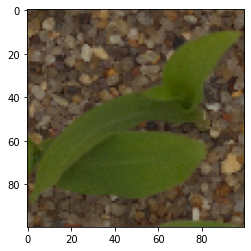

In [51]:
# Define path of prediction image file
pred_img_file_path = os.path.join(out_base_path, "Predict.png")
# Load image file in PIL format
pred_img = load_img(pred_img_file_path, target_size = mod_inp_shape[:2])
# Convert image file from PIL format to numpy array
pred_img_arr = img_to_array(pred_img)
pred_img_arr = np.expand_dims(pred_img_arr, axis = 0)
plt.imshow(pred_img_arr[0].astype('uint8'))

# Pre-process data with the correct pre-processing function
pred_img_arr_preproc = preprocess_data(pred_img_arr)
# Predict output class probabilities for prediction image file
pred_prob = model.predict(pred_img_arr_preproc)
pred_class = class_map[np.argmax(pred_prob)]

print("Predicted class is %s" %pred_class)
print("Prediction probability is %0.2f %%" %(100 * pred_prob[0, np.argmax(pred_prob)]))

## Model - MB1 - Custom CNN model based on VGG16 architecture

* Custom CNN model based on VGG16 architecture. Topology is:
  * Conv(64) -> Conv(64) -> MaxPool
  * Conv(128) -> Conv(128) -> MaxPool
  * Conv(256) -> Conv(256) -> Conv(256) -> MaxPool -> Dropout (rate = 0.5)
  * Conv(512) -> Conv(512) -> Conv(512) -> MaxPool
  * Conv(512) -> Conv(512) -> Conv(512) -> MaxPool -> GlobalAveragePooling -> Dropout (rate = 0.5)
  * Dense(1024, ReLu) -> Dense(512, Relu) -> Dense(12, softmax)
* Optimizer = Adam, initial learning rate = 1e-4, decay rate = 1, decay steps = 50 epochs, trained for 300 epochs.
* Trainable parameters = 15.7M

### Define file paths

In [52]:
### Define file paths
mod_file_pref = "MB_1" 
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") 
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy")

# Load model with final trained weights
model = models.load_model(fm_path) 

# Print model summary
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IL (InputLayer)              [(None, 224, 224, 3)]     0         
_________________________________________________________________
C2D_A1 (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
C2D_A2 (Conv2D)              (None, 224, 224, 64)      36928     
_________________________________________________________________
MXP_A (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
C2D_B1 (Conv2D)              (None, 112, 112, 128)     73856     
_________________________________________________________________
C2D_B2 (Conv2D)              (None, 112, 112, 128)     147584    
_________________________________________________________________
MXP_B (MaxPooling2D)         (None, 56, 56, 128)       0   

### Create dataset for evaluation

In [53]:
bm_name = 'MobileNet'
mod_inp_shape = (224, 224, 3) # Define target image size for model input
mod_bat_size = 32 # Batch size to use while model fitting

# Create train ImageDataGenerator objects without augmentation for evaluation purposes
# Same seed is used as earlier.
train_datagen_eval = ImageDataGenerator(validation_split = 0.25, preprocessing_function = preprocess_data)
train_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                              target_size = mod_inp_shape[:2],\
                                                              class_mode = 'categorical',\
                                                              batch_size = mod_bat_size, shuffle = True,\
                                                              subset = "training", seed = 1234)
val_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                            target_size = mod_inp_shape[:2],\
                                                            class_mode = 'categorical',\
                                                            batch_size = mod_bat_size, shuffle = True,\
                                                            subset = "validation", seed = 1234)

Found 3581 images belonging to 12 classes.
Found 1186 images belonging to 12 classes.


### Evaluate accuracy on train and val sets

In [54]:
### Evaluate model with final trained weights

# Evaluate model on training set
res = model.evaluate(x = train_generator_eval, verbose = 0, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on validation set
res = model.evaluate(x = val_generator_eval, verbose = 0, return_dict = True)
print("Validation set loss is %0.4f" % res['loss'])
print("Validation set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))

Training set loss is 0.1713
Training set accuracy is 95.03 %

Validation set loss is 0.3915
Validation set accuracy is 91.15 %


<b>This model achieves a training set accuracy of 96% and a validation set accuracy of 92%.</b>

### Predict class of 'predict.png'

Predicted class is Maize
Prediction probability is 100.00 %


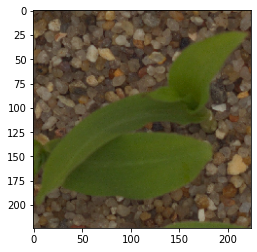

In [55]:
# Define path of prediction image file
pred_img_file_path = os.path.join(out_base_path, "Predict.png")
# Load image file in PIL format
pred_img = load_img(pred_img_file_path, target_size = mod_inp_shape[:2])
# Convert image file from PIL format to numpy array
pred_img_arr = img_to_array(pred_img)
pred_img_arr = np.expand_dims(pred_img_arr, axis = 0)
plt.imshow(pred_img_arr[0].astype('uint8'))

# Pre-process data with the correct pre-processing function
pred_img_arr_preproc = preprocess_data(pred_img_arr)
# Predict output class probabilities for prediction image file
pred_prob = model.predict(pred_img_arr_preproc)
pred_class = class_map[np.argmax(pred_prob)]

print("Predicted class is %s" %pred_class)
print("Prediction probability is %0.2f %%" %(100 * pred_prob[0, np.argmax(pred_prob)]))

## Model - MC_VGG16 - Transfer Learning with pre-trained VGG16 model

* Starting point is pre-trained VGG16 model initialized with 'imagenet' weights. Global average pooling is used to get an output shape of (None, 512) from VGG16 model
* Last 13 layers of VGG16 model re-trained during training with Plant Seedling training set.
* Final layers after VGG16 are:
  * Dropout layer (rate = 0.5)
  * Dense layer (1024, ReLu)
  * Dense layer (512, ReLu)
  * Softmax layer (12 output units)
* Optimizer = Adam, initial learning rate = 1e-4, decay rate = 1, decay steps = 5 epochs, trained for 100 epochs.
* Trainable parameters = 15.5M

### Define file paths

In [56]:
### Define file paths
mod_file_pref = "MC_VGG16" 
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") 
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy")

# Load model with final trained weights
model = models.load_model(fm_path) 

# Print model summary
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Plot learning curves

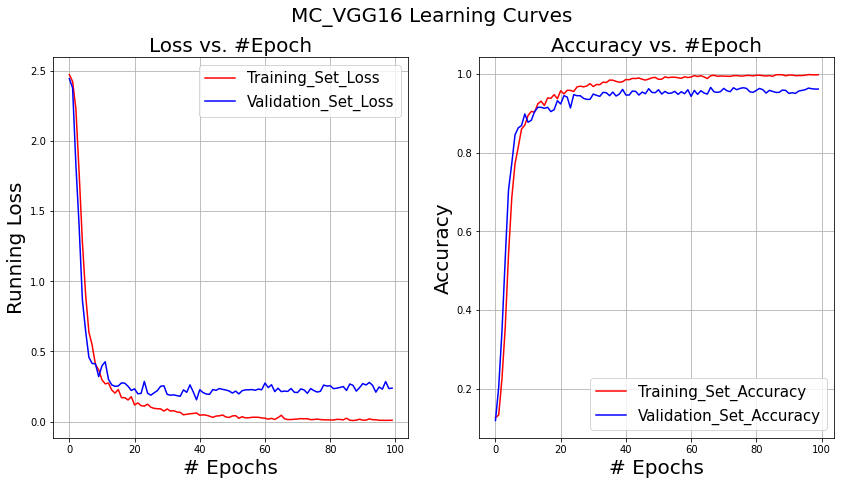

In [57]:
# Load history files from disk
hist_model = np.load(hi_path, allow_pickle = 'TRUE').item()

# Plot training and validation loss
fig = plt.figure(figsize = (14, 7))
fig.suptitle(mod_file_pref + " Learning Curves", fontsize = 20)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(hist_model['loss'], 'r-', label = 'Training_Set_Loss')
ax1.plot(hist_model['val_loss'], 'b-', label = 'Validation_Set_Loss')
ax1.set_title("Loss vs. #Epoch", fontsize = 20)
ax1.set_ylabel('Running Loss', fontsize = 20)
ax1.set_xlabel('# Epochs', fontsize = 20)
ax1.grid(b = True)
ax1.legend(fontsize = 15)

ax2 = plt.subplot(1, 2, 2)
ax2.plot(hist_model['categorical_accuracy'], 'r-', label = 'Training_Set_Accuracy')
ax2.plot(hist_model['val_categorical_accuracy'], 'b-', label = 'Validation_Set_Accuracy')
ax2.set_title("Accuracy vs. #Epoch", fontsize = 20)
ax2.set_ylabel('Accuracy', fontsize = 20)
ax2.set_xlabel('# Epochs', fontsize = 20)
ax2.grid(b = True)
ax2.legend(fontsize = 15)

#plt.tight_layout()
plt.show()

### Create dataset for evaluation

In [58]:
bm_name = 'VGG16'
mod_inp_shape = (224, 224, 3) # Define target image size for model input
mod_bat_size = 32 # Batch size to use while model fitting

# Create train ImageDataGenerator objects without augmentation for evaluation purposes
# Same seed is used as earlier.
train_datagen_eval = ImageDataGenerator(validation_split = 0.25, preprocessing_function = preprocess_data)
train_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                              target_size = mod_inp_shape[:2],\
                                                              class_mode = 'categorical',\
                                                              batch_size = mod_bat_size, shuffle = True,\
                                                              subset = "training", seed = 1234)
val_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                            target_size = mod_inp_shape[:2],\
                                                            class_mode = 'categorical',\
                                                            batch_size = mod_bat_size, shuffle = True,\
                                                            subset = "validation", seed = 1234)

Found 3581 images belonging to 12 classes.
Found 1186 images belonging to 12 classes.


### Evaluate accuracy on train and val sets

In [59]:
### Evaluate model with final trained weights

# Evaluate model on training set
res = model.evaluate(x = train_generator_eval, verbose = 0, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on validation set
res = model.evaluate(x = val_generator_eval, verbose = 0, return_dict = True)
print("Validation set loss is %0.4f" % res['loss'])
print("Validation set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))

Training set loss is 0.0085
Training set accuracy is 99.80 %

Validation set loss is 0.3166
Validation set accuracy is 96.63 %


<b>This model achieves a training set accuracy of 99.8% and a validation set accuracy of 96.63%.</b>

### Predict class of 'predict.png'

Predicted class is Maize
Prediction probability is 100.00 %


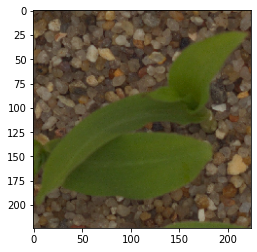

In [60]:
# Define path of prediction image file
pred_img_file_path = os.path.join(out_base_path, "Predict.png")
# Load image file in PIL format
pred_img = load_img(pred_img_file_path, target_size = mod_inp_shape[:2])
# Convert image file from PIL format to numpy array
pred_img_arr = img_to_array(pred_img)
pred_img_arr = np.expand_dims(pred_img_arr, axis = 0)
plt.imshow(pred_img_arr[0].astype('uint8'))

# Pre-process data with the correct pre-processing function
pred_img_arr_preproc = preprocess_data(pred_img_arr)
# Predict output class probabilities for prediction image file
pred_prob = model.predict(pred_img_arr_preproc)
pred_class = class_map[np.argmax(pred_prob)]

print("Predicted class is %s" %pred_class)
print("Prediction probability is %0.2f %%" %(100 * pred_prob[0, np.argmax(pred_prob)]))

## Model - MC_ResNet50 - Transfer Learning with pre-trained ResNet50 model

* Starting point is pre-trained ResNet50 model initialized with 'imagenet' weights. Global average pooling is used to get an output shape of (None, 2048) from the model
* Last 11 layers of ResNet50 model re-trained during training with Plant Seedling training set.
* Final layers after ResNet50 are:
  * Dropout layer (rate = 0.5)
  * Dense layer (1024, ReLu)
  * Dense layer (512, ReLu)
  * Softmax layer (12 output units)
* Optimizer = Adam, initial learning rate = 1e-4, decay rate = 1, decay steps = 20 epochs, trained for 100 epochs.
* Trainable parameters = 7.1M

### Define file paths

In [61]:
### Define file paths
mod_file_pref = "MC_RESNET50" 
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") 
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy")

# Load model with final trained weights
model = models.load_model(fm_path) 

# Print model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Plot learning curves

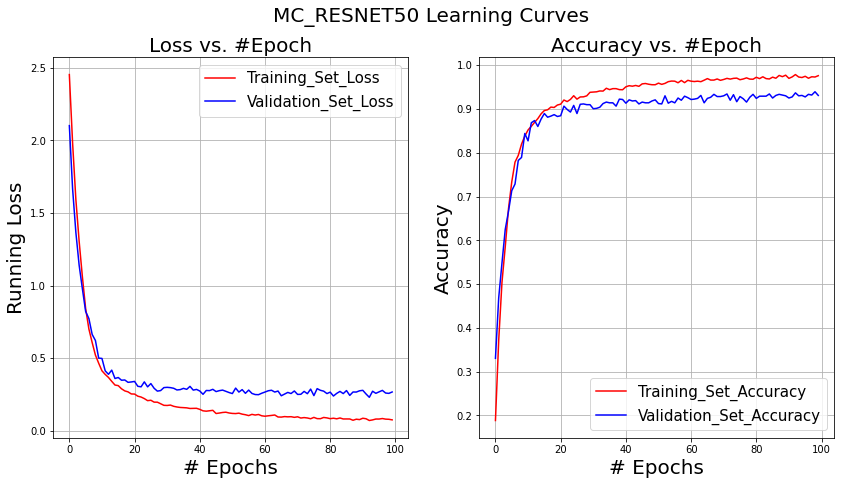

In [62]:
# Load history files from disk
hist_model = np.load(hi_path, allow_pickle = 'TRUE').item()

# Plot training and validation loss
fig = plt.figure(figsize = (14, 7))
fig.suptitle(mod_file_pref + " Learning Curves", fontsize = 20)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(hist_model['loss'], 'r-', label = 'Training_Set_Loss')
ax1.plot(hist_model['val_loss'], 'b-', label = 'Validation_Set_Loss')
ax1.set_title("Loss vs. #Epoch", fontsize = 20)
ax1.set_ylabel('Running Loss', fontsize = 20)
ax1.set_xlabel('# Epochs', fontsize = 20)
ax1.grid(b = True)
ax1.legend(fontsize = 15)

ax2 = plt.subplot(1, 2, 2)
ax2.plot(hist_model['categorical_accuracy'], 'r-', label = 'Training_Set_Accuracy')
ax2.plot(hist_model['val_categorical_accuracy'], 'b-', label = 'Validation_Set_Accuracy')
ax2.set_title("Accuracy vs. #Epoch", fontsize = 20)
ax2.set_ylabel('Accuracy', fontsize = 20)
ax2.set_xlabel('# Epochs', fontsize = 20)
ax2.grid(b = True)
ax2.legend(fontsize = 15)

#plt.tight_layout()
plt.show()

### Create dataset for evaluation

In [63]:
bm_name = 'ResNet50'
mod_inp_shape = (224, 224, 3) # Define target image size for model input
mod_bat_size = 32 # Batch size to use while model fitting

# Create train ImageDataGenerator objects without augmentation for evaluation purposes
# Same seed is used as earlier.
train_datagen_eval = ImageDataGenerator(validation_split = 0.25, preprocessing_function = preprocess_data)
train_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                              target_size = mod_inp_shape[:2],\
                                                              class_mode = 'categorical',\
                                                              batch_size = mod_bat_size, shuffle = True,\
                                                              subset = "training", seed = 1234)
val_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                            target_size = mod_inp_shape[:2],\
                                                            class_mode = 'categorical',\
                                                            batch_size = mod_bat_size, shuffle = True,\
                                                            subset = "validation", seed = 1234)

Found 3581 images belonging to 12 classes.
Found 1186 images belonging to 12 classes.


### Evaluate accuracy on train and val sets

In [64]:
### Evaluate model with final trained weights

# Evaluate model on training set
res = model.evaluate(x = train_generator_eval, verbose = 0, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on validation set
res = model.evaluate(x = val_generator_eval, verbose = 0, return_dict = True)
print("Validation set loss is %0.4f" % res['loss'])
print("Validation set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))

Training set loss is 0.0326
Training set accuracy is 98.74 %

Validation set loss is 0.2973
Validation set accuracy is 93.51 %


<b>This model achieves a training set accuracy of 98.74% and a validation set accuracy of 93.5%.</b>

### Predict class of 'predict.png'

Predicted class is Maize
Prediction probability is 100.00 %


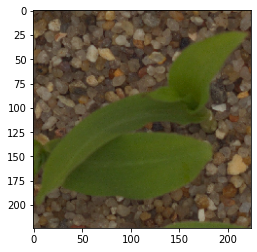

In [65]:
# Define path of prediction image file
pred_img_file_path = os.path.join(out_base_path, "Predict.png")
# Load image file in PIL format
pred_img = load_img(pred_img_file_path, target_size = mod_inp_shape[:2])
# Convert image file from PIL format to numpy array
pred_img_arr = img_to_array(pred_img)
pred_img_arr = np.expand_dims(pred_img_arr, axis = 0)
plt.imshow(pred_img_arr[0].astype('uint8'))

# Pre-process data with the correct pre-processing function
pred_img_arr_preproc = preprocess_data(pred_img_arr)
# Predict output class probabilities for prediction image file
pred_prob = model.predict(pred_img_arr_preproc)
pred_class = class_map[np.argmax(pred_prob)]

print("Predicted class is %s" %pred_class)
print("Prediction probability is %0.2f %%" %(100 * pred_prob[0, np.argmax(pred_prob)]))

## Model - MC_MOBNET - Transfer Learning with pre-trained MobileNet model

* Starting point is pre-trained MobileNet model initialized with 'imagenet' weights. Global average pooling is used to get an output shape of (None, 1024) from the model
* Last 26 layers of MobileNet model re-trained during training with Plant Seedling training set.
* Final layers after ResNet50 are:
  * Dropout layer (rate = 0.5)
  * Dense layer (1024, ReLu)
  * Dense layer (512, ReLu)
  * Softmax layer (12 output units)
* Optimizer = Adam, initial learning rate = 1e-4, decay rate = 1, decay steps = 5 epochs, trained for 100 epochs.
* Trainable parameters = 3.7M

### Define file paths

In [66]:
### Define file paths
mod_file_pref = "MC_MOBNET" 
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") 
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy")

# Load model with final trained weights
model = models.load_model(fm_path) 

# Print model summary
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

### Plot learning curves

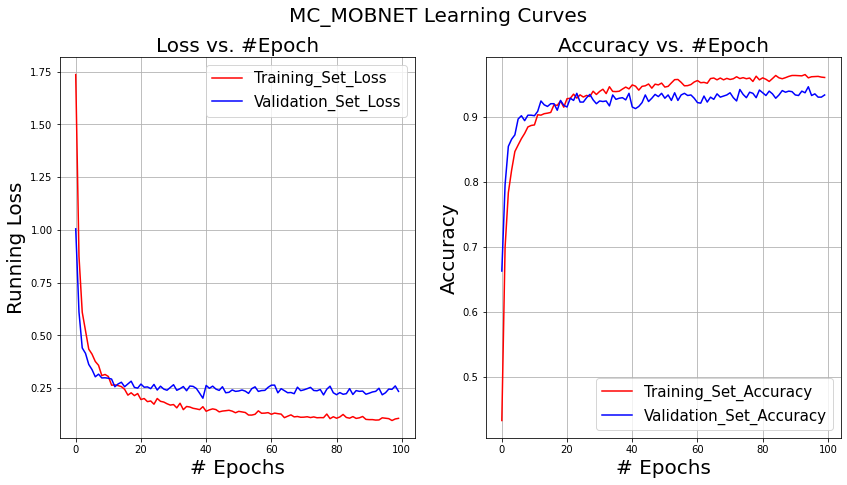

In [67]:
# Load history files from disk
hist_model = np.load(hi_path, allow_pickle = 'TRUE').item()

# Plot training and validation loss
fig = plt.figure(figsize = (14, 7))
fig.suptitle(mod_file_pref + " Learning Curves", fontsize = 20)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(hist_model['loss'], 'r-', label = 'Training_Set_Loss')
ax1.plot(hist_model['val_loss'], 'b-', label = 'Validation_Set_Loss')
ax1.set_title("Loss vs. #Epoch", fontsize = 20)
ax1.set_ylabel('Running Loss', fontsize = 20)
ax1.set_xlabel('# Epochs', fontsize = 20)
ax1.grid(b = True)
ax1.legend(fontsize = 15)

ax2 = plt.subplot(1, 2, 2)
ax2.plot(hist_model['categorical_accuracy'], 'r-', label = 'Training_Set_Accuracy')
ax2.plot(hist_model['val_categorical_accuracy'], 'b-', label = 'Validation_Set_Accuracy')
ax2.set_title("Accuracy vs. #Epoch", fontsize = 20)
ax2.set_ylabel('Accuracy', fontsize = 20)
ax2.set_xlabel('# Epochs', fontsize = 20)
ax2.grid(b = True)
ax2.legend(fontsize = 15)

#plt.tight_layout()
plt.show()

### Create dataset for evaluation

In [68]:
bm_name = 'MobileNet'
mod_inp_shape = (224, 224, 3) # Define target image size for model input
mod_bat_size = 32 # Batch size to use while model fitting

# Create train ImageDataGenerator objects without augmentation for evaluation purposes
# Same seed is used as earlier.
train_datagen_eval = ImageDataGenerator(validation_split = 0.25, preprocessing_function = preprocess_data)
train_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                              target_size = mod_inp_shape[:2],\
                                                              class_mode = 'categorical',\
                                                              batch_size = mod_bat_size, shuffle = True,\
                                                              subset = "training", seed = 1234)
val_generator_eval = train_datagen_eval.flow_from_directory(train_set_path, color_mode = 'rgb', \
                                                            target_size = mod_inp_shape[:2],\
                                                            class_mode = 'categorical',\
                                                            batch_size = mod_bat_size, shuffle = True,\
                                                            subset = "validation", seed = 1234)

Found 3581 images belonging to 12 classes.
Found 1186 images belonging to 12 classes.


### Evaluate accuracy on train and val sets

In [69]:
### Evaluate model with final trained weights

# Evaluate model on training set
res = model.evaluate(x = train_generator_eval, verbose = 0, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on validation set
res = model.evaluate(x = val_generator_eval, verbose = 0, return_dict = True)
print("Validation set loss is %0.4f" % res['loss'])
print("Validation set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))

Training set loss is 0.0213
Training set accuracy is 99.39 %

Validation set loss is 0.2169
Validation set accuracy is 95.53 %


<b>This model achieves a training set accuracy of 99.39% and a validation set accuracy of 95.53%.</b>

### Predict class of 'predict.png'

Predicted class is Maize
Prediction probability is 100.00 %


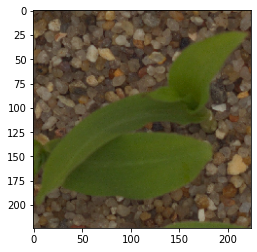

In [70]:
# Define path of prediction image file
pred_img_file_path = os.path.join(out_base_path, "Predict.png")
# Load image file in PIL format
pred_img = load_img(pred_img_file_path, target_size = mod_inp_shape[:2])
# Convert image file from PIL format to numpy array
pred_img_arr = img_to_array(pred_img)
pred_img_arr = np.expand_dims(pred_img_arr, axis = 0)
plt.imshow(pred_img_arr[0].astype('uint8'))

# Pre-process data with the correct pre-processing function
pred_img_arr_preproc = preprocess_data(pred_img_arr)
# Predict output class probabilities for prediction image file
pred_prob = model.predict(pred_img_arr_preproc)
pred_class = class_map[np.argmax(pred_prob)]

print("Predicted class is %s" %pred_class)
print("Prediction probability is %0.2f %%" %(100 * pred_prob[0, np.argmax(pred_prob)]))

### Generate predictions on test set

In [71]:
# Create test ImageDataGenerator object
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_data)

# Create test generator
test_generator = test_datagen.flow_from_directory(test_set_path, target_size = mod_inp_shape[:2],\
                                                  color_mode = 'rgb', class_mode = None,\
                                                  batch_size = mod_bat_size, shuffle = False)

num_batches_test = test_generator.__len__()

# Print information about test dataset
print()
print("Test_Set_Information")
print("====================")
print("Number of samples in test dataset: %d" % test_generator.samples)
print("Number of batches in test dataset: %d" % num_batches_test)

Found 794 images belonging to 1 classes.

Test_Set_Information
Number of samples in test dataset: 794
Number of batches in test dataset: 25


In [72]:
y_pred_test = model.predict(x = test_generator, verbose = 0)
test_labels = np.argmax(y_pred_test, axis = 1)
test_classes = [class_map[ind] for ind in test_labels]

test_res_df = pd.DataFrame(columns = ['file', 'species'])
for ind, fname in enumerate(tqdm(test_generator.filenames)):
  entry_dict = {'file': fname.split("/")[1],
                'species': test_classes[ind]}
  test_res_df = test_res_df.append(entry_dict, ignore_index = True)

test_res_file_path = os.path.join(out_base_path, 'sample_submission.csv')
test_res_df.to_csv(test_res_file_path, index = False)
print()
display(test_res_df.head(10))

100%|██████████| 794/794 [00:01<00:00, 485.57it/s]


,file,species
0,0021e90e4.png,Small-flowered Cranesbill
1,003d61042.png,Fat Hen
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Sugar beet
5,00d090cde.png,Black-grass
6,00ef713a8.png,Common Chickweed
7,01291174f.png,Fat Hen
8,026716f9b.png,Loose Silky-bent
9,02cfeb38d.png,Loose Silky-bent


### Pickle this model

In [73]:
%%capture
!pip install keras-pickle-wrapper
from keras_pickle_wrapper import KerasPickleWrapper

In [74]:
wrap_model = KerasPickleWrapper(model) # Wrap Keras model using KerasPickleWrapper
pkl_filename = out_base_path + "model.pkl" # Define pickle file name

# Write wrapped Keras model to pickle file
with open(pkl_filename, 'wb') as file:  
    pickle.dump(wrap_model, file)
print("Pickle file created")    

Pickle file created


In [75]:
# Load pickle file and display model summary
pkl_filename = out_base_path + "model.pkl" # Define pickle file name
with open(pkl_filename, 'rb') as file:  
    new_model = pickle.load(file)
model_keras = new_model() # Extract Keras model from wrapper
model_keras.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

# Final Summary



1. In this notebook, we evaluated multiple classifiers on the plant seedling dataset.
2. The original data in the zip file was copied to the local workspace and initially analyzed. The results were then stored in an xls file.
3. Image data generator objects were created with various augmentation techniques and appropriate pre-processing functions.
4. Two supervised learning classifiers(SVM and XGBoost) were first evaluated. PCA was also done on the dataset. Both classifiers performed poorly on cross validation as expected. This is mainly because images represent unstructured data that traditional supervised learning algorithms are not very suited for. Also, the number of features (30K) far exceeds the number of training samples (~5K) resulting in heavy overfitting of the classifiers. It is also not very easy to perform feature engineering and appropriate feature extraction on images.
5. As the next step, multiple dense NN (DNN) based architectures were evaluated. Significant challenges were faced during training with DNN's. Without any data augmentation, the NN fits easily to the training set but there is huge overfitting resulting in a high training set accuracy but poor validation accuracy of around 50%. With data augmentation, the training becomes very slow and it takes a long time to get the training accuracy to around 70 to 80%. However, even with this, the validation accuracy is still only around 64%.
6. In the 3rd step, a custom CNN model was built based on the VGG16 architecture and trained from scratch using the plant seedling dataset. Image augmentation, global average pooling and dropout layers were used to reduce overfitting. This model trains much faster than the DNN's and achieved 96% accuracy on the training set and 92% accuracy on the validation set. This can probably be further improved by optimizing the dropout rates, extent of image augmentation and learning rate scheduling. However, the fact that out training set has only 4000 samples would still limit the generalization performance of the model.
7. Finally, transfer learning wad done on three pre-trained models (VGG16, ResNet50, MobileNet), all of which used 'ImageNet' weights as the starting weights. As expected, these architectures train very quickly and yield the best performance. Best validation accuracy of 96.63% was achieved with the VGG16 model. Furthe improvements in performance can be obtained by optimizing the drop-out rates, finer control of image augmentation and learning rate scheduling and stacking / ensembling multiple models together.


